#1. Baseline model

In [11]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error, r2_score, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK
from hyperopt.pyll.base import scope

In [14]:
np.random.seed(42)

In [15]:
heart_attack_df = pd.read_csv("heart.csv")
heart_attack_df.head()

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [16]:
heart_attack_df.describe()

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.366337,0.683168,0.966997,131.623762,246.264026,0.148515,0.528053,149.646865,0.326733,1.039604,1.399340,0.729373,2.313531,0.544554
std,9.082101,0.466011,1.032052,17.538143,51.830751,0.356198,0.525860,22.905161,0.469794,1.161075,0.616226,1.022606,0.612277,0.498835
min,29.000000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,47.500000,0.000000,0.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,55.000000,1.000000,1.000000,130.000000,240.000000,0.000000,1.000000,153.000000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000
75%,61.000000,1.000000,2.000000,140.000000,274.500000,0.000000,1.000000,166.000000,1.000000,1.600000,2.000000,1.000000,3.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000,1.000000


In [17]:
x = heart_attack_df.drop(columns="output")
y = heart_attack_df["output"]

In [18]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 2021)

In [19]:
scaler= StandardScaler()
x_train=scaler.fit_transform(x_train)
x_test=scaler.transform(x_test)

In [20]:
model = RandomForestClassifier(random_state=42)
model.fit(x_train, y_train)

pred = model.predict(x_test)

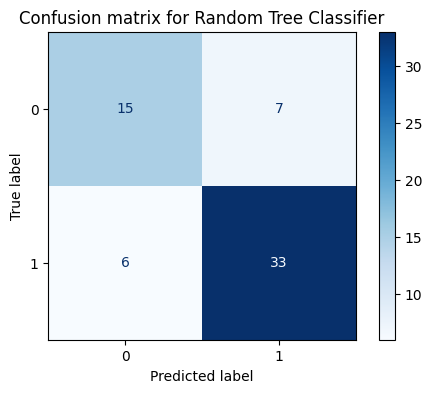

Accuracy: 0.79
Precision: 0.82
Recall: 0.85


In [21]:
cm = confusion_matrix(y_test, pred, labels=[False, True])

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
fig, ax = plt.subplots(figsize=(6, 4))
disp.plot(ax=ax, cmap='Blues', values_format='d')

# Set title and show plot
plt.title(f"Confusion matrix for Random Tree Classifier")
plt.show()

## Calculate accuracy, precision, recall
accuracy = accuracy_score(y_test, pred)
precision = precision_score(y_test, pred)
recall = recall_score(y_test, pred)

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")

In [22]:
mse = mean_squared_error(y_test, pred)
accuracy = model.score(x_test, y_test)

print("Accuracy:", accuracy)
print("Mean Squared Error:", mse)

Accuracy: 0.7868852459016393
Mean Squared Error: 0.21311475409836064
R2 Score: 0.07575757575757569


#2. Hyperopt

In [23]:
def objective(params):
  dt = RandomForestClassifier()
  dt.fit(x_train, y_train)
  y_pred = dt.predict(x_test)
  mse = mean_squared_error(y_test, y_pred)
  return {'loss': mse, 'status': STATUS_OK}

In [24]:
# Define search space for RandomForest model
search_space = {
    'n_estimators': scope.int(hp.quniform('n_estimators', 50, 300, 10)),  # Number of trees in the forest
    'max_depth': scope.int(hp.quniform('max_depth', 2, 20, 1)),  # Tree depth
    'min_samples_split': scope.int(hp.quniform('min_samples_split', 2, 20, 1)),  # Minimum samples required to split an internal node
    'min_samples_leaf': scope.int(hp.quniform('min_samples_leaf', 1, 50, 1)),  # Minimum samples at a leaf node
    'max_features': hp.choice('max_features', ['auto', 'sqrt', 'log2', None]),  # Number of features to consider at each split
    'bootstrap': hp.choice('bootstrap', [True, False]),  # Whether bootstrap samples are used
    'criterion': hp.choice('criterion', ['gini', 'entropy', 'log_loss']),  # Function to measure split quality
    'class_weight': hp.choice('class_weight', [None, 'balanced', 'balanced_subsample']),  # Class weights
    'random_state': 42
}

In [25]:
trials = Trials()

In [27]:
best = fmin(fn=objective,
            space=search_space,
            algo=tpe.suggest,
            max_evals = 200,
            trials = trials,
            rstate = np.random.default_rng(42))
print("Best hyperparameters found: ", best)

100%|██████████| 200/200 [00:27<00:00,  3.69trial/s, best loss: 0.16393442622950818]
Best hyperparameters found:  {'bootstrap': 0, 'class_weight': 1, 'criterion': 0, 'max_depth': 11.0, 'max_features': 2, 'min_samples_leaf': 33.0, 'min_samples_split': 14.0, 'n_estimators': 210.0}


In [28]:
hyperopt_model = RandomForestClassifier(bootstrap=True, class_weight='balanced', criterion='gini', max_depth=11,
                                        max_features='log2', min_samples_leaf=33, min_samples_split=14, n_estimators=210, random_state=42)
hyperopt_model.fit(x_train, y_train)

pred = hyperopt_model.predict(x_test)

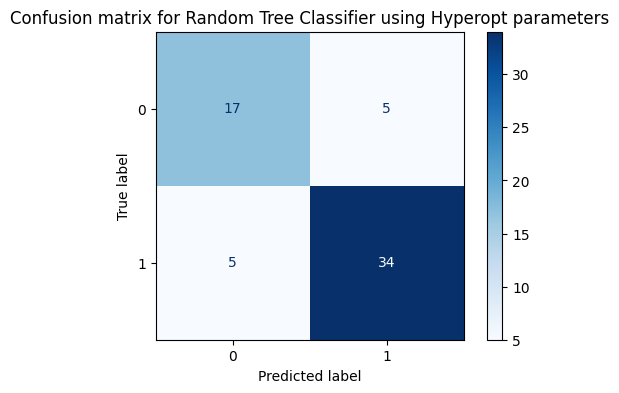

Accuracy: 0.84
Precision: 0.87
Recall: 0.87


In [29]:
cm = confusion_matrix(y_test, pred, labels=[False, True])

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
fig, ax = plt.subplots(figsize=(6, 4))
disp.plot(ax=ax, cmap='Blues', values_format='d')

# Set title and show plot
plt.title(f"Confusion matrix for Random Tree Classifier using Hyperopt parameters")
plt.show()

## Calculate accuracy, precision, recall
accuracy = accuracy_score(y_test, pred)
precision = precision_score(y_test, pred)
recall = recall_score(y_test, pred)

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")

In [32]:
mse = mean_squared_error(y_test, pred)
r2 = r2_score(y_test, pred)
accuracy = hyperopt_model.score(x_test, y_test)

print("Accuracy:", accuracy)
print("Mean Squared Error:", mse)

Accuracy: 0.8360655737704918
Mean Squared Error: 0.16393442622950818
